## Initialization

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from os.path import isfile

import config
import utils
import data_path
import data_loader

from classifier import Classifier
from feature_generator import generate_features

## Config

In [2]:
START_SIZE = 100
INDUCTIVE_STEP_SIZE = 10
STEPS = 100
RANDOM_STATE = 0

## Load Features

In [3]:
embedding_features = pd.read_csv(os.path.join(data_path.DATA_PATH, 'train', 'embedding_fasttext.csv'), index_col=0)
psychological_features = pd.read_csv(os.path.join(data_path.DATA_PATH, 'train', 'psychological_features.csv'), index_col=0)
structural_features = pd.read_csv(os.path.join(data_path.DATA_PATH, 'train', 'structural_features.csv'), index_col=0)
syntactics_features = pd.read_csv(os.path.join(data_path.DATA_PATH, 'train', 'syntactics_features.csv'), index_col=0)
text_dependent_features = pd.read_csv(os.path.join(data_path.DATA_PATH, 'train', 'text_dependent_features.csv'), index_col=0)
word_dependent_features = pd.read_csv(os.path.join(data_path.DATA_PATH, 'train', 'word_dependent_features.csv'), index_col=0)

features_list_train = [embedding_features, psychological_features, structural_features, syntactics_features, text_dependent_features, word_dependent_features]

In [4]:
embedding_features_test = pd.read_csv(os.path.join(data_path.DATA_PATH, 'test', 'embedding_fasttext.csv'), index_col=0)
psychological_features_test = pd.read_csv(os.path.join(data_path.DATA_PATH, 'test', 'psychological_features.csv'), index_col=0)
structural_features_test = pd.read_csv(os.path.join(data_path.DATA_PATH, 'test', 'structural_features.csv'), index_col=0)
syntactics_features_test = pd.read_csv(os.path.join(data_path.DATA_PATH, 'test', 'syntactics_features.csv'), index_col=0)
text_dependent_features_test = pd.read_csv(os.path.join(data_path.DATA_PATH, 'test', 'text_dependent_features.csv'), index_col=0)
word_dependent_features_test = pd.read_csv(os.path.join(data_path.DATA_PATH, 'test', 'word_dependent_features.csv'), index_col=0)

features_list_test = [embedding_features_test, psychological_features_test, structural_features_test, syntactics_features_test, text_dependent_features_test, word_dependent_features_test]

## Create Train Test Pandas Dataframe

In [5]:
train_pdf = utils.create_dataframe_from_feature_list(features_list_train)
test_pdf = utils.create_dataframe_from_feature_list(features_list_test)

train_pdf.shape, test_pdf.shape

((2000, 338), (378, 338))

## Split Features and Labels

In [6]:
train_features, train_labels = utils.split_features_and_labels(train_pdf, 'label')
test_features, test_labels = utils.split_features_and_labels(test_pdf, 'label')

## Normalize

In [7]:
scaler = StandardScaler()

scaler.fit(train_features)

train_features = pd.DataFrame(scaler.transform(train_features), columns=train_features.columns)
test_features = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)

## Active Learning

### Initiate Train Index set

In [8]:
female_train_idx = list(train_pdf[train_pdf['label'] == 0].index[:START_SIZE])
male_train_idx = list(train_pdf[train_pdf['label'] == 1].index[:START_SIZE])

train_idx = female_train_idx + male_train_idx

### Learing Loop

In [9]:
def update_train_index(prediction_proba, labels, limit):
    diff_preds = [abs(prediction_proba[index][0] - prediction_proba[index][1]) for index, ـ in enumerate(labels)]
    sort_indexes = np.argsort(diff_preds)
    female_idx = []
    male_idx = []
    for idx in sort_indexes:
        if (len(female_idx) == limit) and (len(male_idx) == limit):
            return male_idx + female_idx
        if (len(female_idx) < limit) and (labels.iloc[idx] == 0):
            female_idx.append(idx)
        elif (len(male_idx) < limit) and (labels.iloc[idx] == 1):
            male_idx.append(idx)
    return male_idx + female_idx

In [10]:
accuracy_per_step = []
classifier = Classifier('SVM' , kernel='rbf', gamma='auto', tol=0.01, C=1, random_state=RANDOM_STATE)

for step in range(STEPS):

    X_train_subset = train_features.filter(train_idx, axis=0)
    y_train_subset = train_labels.filter(train_idx, axis=0)

    classifier.fit(X_train_subset, y_train_subset)

    train_accuracy = utils.calculate_accuracy(classifier, train_features, train_labels)
    train_subset_accuracy = utils.calculate_accuracy(classifier, X_train_subset, y_train_subset)

    accuracy_per_step.append({'train':train_accuracy, 'subset':train_subset_accuracy})
    print( 'Step {} '.format(step), 
            " : - train accuracy={:.2f}, \t".format(train_accuracy),
            "subset accuracy={:.2f}, \t".format(train_subset_accuracy),
            "train size=" , len(train_idx))

    train_idx += update_train_index(
        classifier.predict(train_features),
        train_labels,
        INDUCTIVE_STEP_SIZE
    )

Step 0   : - train accuracy=0.57, 	 subset accuracy=0.93, 	 train size= 200
Step 1   : - train accuracy=0.60, 	 subset accuracy=0.93, 	 train size= 220
Step 2   : - train accuracy=0.61, 	 subset accuracy=0.92, 	 train size= 240
Step 3   : - train accuracy=0.61, 	 subset accuracy=0.94, 	 train size= 260
Step 4   : - train accuracy=0.62, 	 subset accuracy=0.93, 	 train size= 280
Step 5   : - train accuracy=0.61, 	 subset accuracy=0.93, 	 train size= 300
Step 6   : - train accuracy=0.63, 	 subset accuracy=0.93, 	 train size= 320
Step 7   : - train accuracy=0.64, 	 subset accuracy=0.93, 	 train size= 340
Step 8   : - train accuracy=0.64, 	 subset accuracy=0.93, 	 train size= 360
Step 9   : - train accuracy=0.65, 	 subset accuracy=0.93, 	 train size= 380
Step 10   : - train accuracy=0.65, 	 subset accuracy=0.94, 	 train size= 400
Step 11   : - train accuracy=0.65, 	 subset accuracy=0.92, 	 train size= 420
Step 12   : - train accuracy=0.66, 	 subset accuracy=0.92, 	 train size= 440
Step 13  

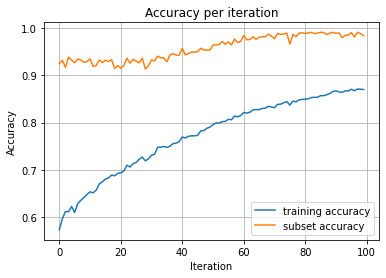

In [11]:
x = np.arange(STEPS)
y_list = {
    'training accuracy': [item['train'] for item in accuracy_per_step],
    'subset accuracy': [item['subset'] for item in accuracy_per_step]
}

utils.plot_line_chart(
    x=x,
    y_list=y_list,
    xlabel='Iteration',
    ylabel='Accuracy',
    title='Accuracy per iteration'
)

In [12]:
print('Accuracy on testset : {}'.format(utils.calculate_accuracy(classifier, test_features, test_labels)*100))

Accuracy on testset : 61.37566137566137
